In [2]:
import os
import glob
import cv2
import imageio

import numpy as np 
import pandas as pd 
import nibabel as nib
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from ipywidgets import *
from PIL import Image
from matplotlib.pyplot import figure

from fastai.basics import *
from fastai.vision.all import *
from fastai.data.transforms import *

In [3]:
# Create a meta file for nii files processing
dataset_path = r"C:\Users\HP\Documents\CT Scans\volumes"
file_list = []

for dirname, _, filenames in os.walk(dataset_path):
    for filename in filenames:
        file_list.append((dirname, filename))

df_files = pd.DataFrame(file_list, columns =['dirname', 'filename']) 
df_files.sort_values(by=['filename'], ascending=True)

,dirname,filename
0,C:\Users\HP\Documents\CT Scans\volumes,volume-0.nii
1,C:\Users\HP\Documents\CT Scans\volumes,volume-1.nii
2,C:\Users\HP\Documents\CT Scans\volumes,volume-10.nii
3,C:\Users\HP\Documents\CT Scans\volumes,volume-11.nii
4,C:\Users\HP\Documents\CT Scans\volumes,volume-12.nii
5,C:\Users\HP\Documents\CT Scans\volumes,volume-13.nii
6,C:\Users\HP\Documents\CT Scans\volumes,volume-14.nii
7,C:\Users\HP\Documents\CT Scans\volumes,volume-15.nii
8,C:\Users\HP\Documents\CT Scans\volumes,volume-16.nii
9,C:\Users\HP\Documents\CT Scans\volumes,volume-17.nii


In [5]:
# Map CT scan and label 

# Add 2 new columns for the segmentations
df_files["seg_dirname"]  = ""
df_files["seg_filename"] = ""

for i in range(131):
    ct = f"volume-{i}.nii"
    mask = f"segmentation-{i}.nii"
    
    df_files.loc[df_files['filename'] == ct, 'seg_filename'] = mask
    df_files.loc[df_files['filename'] == ct, 'seg_dirname'] = r"C:\Users\HP\Documents\CT Scans\segmentations"

# drop segment rows
df_files = df_files[df_files.seg_filename != ''].sort_values(by=['filename']).reset_index(drop=True)
print(df_files.head())
print(len(df_files))

                                  dirname       filename  \
0  C:\Users\HP\Documents\CT Scans\volumes   volume-0.nii   
1  C:\Users\HP\Documents\CT Scans\volumes   volume-1.nii   
2  C:\Users\HP\Documents\CT Scans\volumes  volume-10.nii   
3  C:\Users\HP\Documents\CT Scans\volumes  volume-11.nii   
4  C:\Users\HP\Documents\CT Scans\volumes  volume-12.nii   

                                    seg_dirname         seg_filename  
0  C:\Users\HP\Documents\CT Scans\segmentations   segmentation-0.nii  
1  C:\Users\HP\Documents\CT Scans\segmentations   segmentation-1.nii  
2  C:\Users\HP\Documents\CT Scans\segmentations  segmentation-10.nii  
3  C:\Users\HP\Documents\CT Scans\segmentations  segmentation-11.nii  
4  C:\Users\HP\Documents\CT Scans\segmentations  segmentation-12.nii  
51


In [4]:
def read_nii(filepath):
    '''
    Reads .nii file and returns pixel array
    '''
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array))
    return(array)

In [9]:
# Read sample

sample = 0
sample_ct = read_nii(df_files.loc[sample,'dirname']+"/"+df_files.loc[sample,'filename'])
sample_seg = read_nii(df_files.loc[sample,'seg_dirname']+"/"+df_files.loc[sample,'seg_filename'])

print(f'CT Shape:   {sample_ct.shape}\nSegmentation Shape: {sample_seg.shape}')

CT Shape:   (512, 512, 75)
Segmentation Shape: (512, 512, 75)


In [11]:
print(np.amin(sample_ct), np.amax(sample_ct))
print(np.amin(sample_seg), np.amax(sample_seg))

-3024.0 1410.0
0.0 2.0


### Medical Image Windowing

In [6]:
dicom_windows = types.SimpleNamespace(
    brain=(80,40),
    subdural=(254,100),
    stroke=(8,32),
    brain_bone=(2800,600),
    brain_soft=(375,40),
    lungs=(1500,-600),
    mediastinum=(350,50),
    abdomen_soft=(400,50),
    liver=(180,60),
    spine_soft=(250,50),
    spine_bone=(1800,400),
    custom = (200,60)
)

@patch
def windowed(self:Tensor, w, l):
    px = self.clone()
    px_min = l - w//2 # -45 for liver (Hounsfield Units)
    px_max = l + w//2 # 105 for liver (Hounsfield Units)
    px[px<px_min] = px_min
    px[px>px_max] = px_max
    return (px-px_min) / (px_max-px_min)

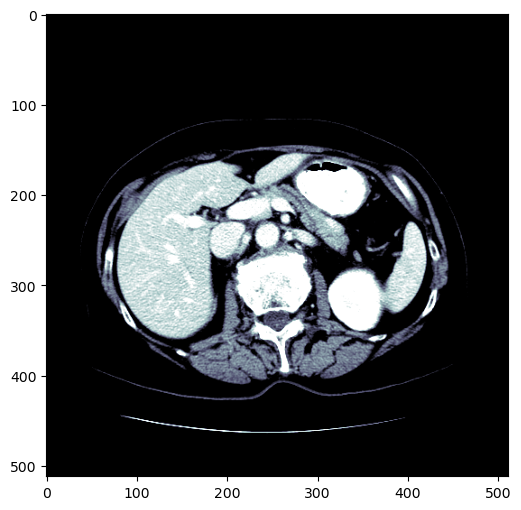

In [ ]:
figure(figsize=(8, 6), dpi=100)
plt.imshow(tensor(sample_ct[..., 55].astype(np.float32)).windowed(*dicom_windows.liver), cmap=plt.cm.bone);

In [15]:
def plot_sample(array_list, color_map = 'nipy_spectral'):
    '''
    Plots and a slice with all available annotations
    '''
    fig = plt.figure(figsize=(20,16), dpi=100)

    plt.subplot(1,4,1)
    plt.imshow(array_list[0], cmap='bone')
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1,4,2)
    plt.imshow(tensor(array_list[0].astype(np.float32)).windowed(*dicom_windows.liver), cmap='bone');
    plt.title('Windowed Image')
    plt.axis('off')
             
    plt.subplot(1,4,3)
    plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    plt.title('Mask')
    plt.axis('off')
    
    plt.subplot(1,4,4)
    plt.imshow(array_list[0], cmap='bone')
    plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    plt.title('Liver & Mask')
    plt.axis('off')
    
    plt.show()

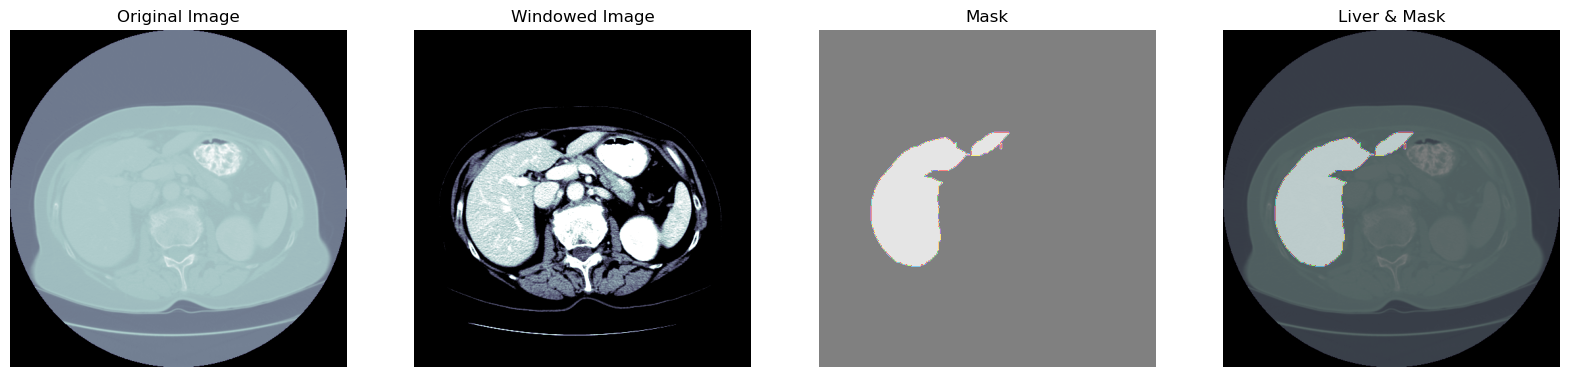

In [17]:
sample = 55

sample_slice = tensor(sample_ct[...,sample].astype(np.float32))

plot_sample([sample_ct[..., sample],
             sample_seg[..., sample]])

### Multi-Channel Preprocessing

In [8]:
class TensorCTScan(TensorImageBW): _show_args = {'cmap':'bone'}

# Frequency-Based Histogram Binning
"A function to split the range of pixel values into groups, such that each group has around the same number of pixels"
@patch
def freqhist_bins(self:Tensor, n_bins=100):
    imsd = self.view(-1).sort()[0]
    t = torch.cat([tensor([0.001]),
                   torch.arange(n_bins).float()/n_bins+(1/2/n_bins),
                   tensor([0.999])])
    t = (len(imsd)*t).long()
    return imsd[t].unique()

# Histogram Scaling
"Scales a tensor using `freqhist_bins` to values between 0 and 1"
@patch
def hist_scaled(self:Tensor, brks=None):
    if self.device.type=='cuda': return self.hist_scaled_pt(brks)
    if brks is None: brks = self.freqhist_bins()
    ys = np.linspace(0., 1., len(brks))
    x = self.numpy().flatten()
    x = np.interp(x, brks.numpy(), ys)
    return tensor(x).reshape(self.shape).clamp(0.,1.)
    
# Multi-Channel Creation
"Creates one channel for each windowing parameter, each channel emphasizes different tissue types"
@patch
def to_nchan(x:Tensor, wins, bins=None):
    res = [x.windowed(*win) for win in wins]
    if not isinstance(bins,int) or bins!=0: res.append(x.hist_scaled(bins).clamp(0,1))
    dim = [0,1][x.dim()==3]
    return TensorCTScan(torch.stack(res, dim=dim))

# Save as Multi-Channel JPEG
@patch
def save_jpg(x:(Tensor), path, wins, bins=None, quality=120):
    fn = Path(path).with_suffix('.jpg')
    x = (x.to_nchan(wins, bins)*255).byte()
    im = Image.fromarray(x.permute(1,2,0).numpy(), mode=['RGB','CMYK'][x.shape[0]==4])
    im.save(fn, quality=quality)

<Axes: >

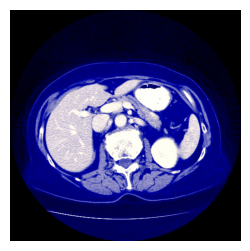

In [ ]:
_,axs = subplots(1,1)
sample_slice.save_jpg('test.jpg', [dicom_windows.liver, dicom_windows.custom])
show_image(Image.open('test.jpg'), ax=axs[0], figsize=(8, 6))

### Training

In [26]:
os.makedirs('train_images',exist_ok=True)
os.makedirs('train_masks',exist_ok=True)

for ii in range(0,len(df_files),2): # take 1/2 nii files for training
    curr_ct        = read_nii(df_files.loc[ii,'dirname']+"/"+df_files.loc[ii,'filename'])
    curr_mask      = read_nii(df_files.loc[ii,'seg_dirname']+"/"+df_files.loc[ii,'seg_filename'])
    curr_file_name = str(df_files.loc[ii,'filename']).split('.')[0]
    curr_dim       = curr_ct.shape[2] # 512, 512, curr_dim

    for curr_slice in range(0,curr_dim,2): # export every 2nd slice for training
        data = tensor(curr_ct[...,curr_slice].astype(np.float32))
        mask = Image.fromarray(curr_mask[...,curr_slice].astype('uint8'), mode="L")
        data.save_jpg(f"train_images/{curr_file_name}_slice_{curr_slice}.jpg", [dicom_windows.liver,dicom_windows.custom])
        mask.save(f"train_masks/{curr_file_name}_slice_{curr_slice}_mask.png")

In [16]:
BATCH_SIZE = 16
IMAGE_SIZE = 256

path = Path('.')

codes = np.array(["background","liver","tumor"])
    
def get_x(fname:Path): return fname
def label_func(x): return path/'train_masks'/f'{x.stem}_mask.png'

tfms = [IntToFloatTensor(),Normalize()]

db = DataBlock(blocks=(ImageBlock(),MaskBlock(codes)),  #codes = {"Backround": 0,"Liver": 1,"Tumor": 2}
               batch_tfms=tfms,
               splitter=RandomSplitter(),
               item_tfms=[Resize(IMAGE_SIZE)],
               get_items=get_image_files,
               get_y=label_func)

ds = db.datasets(source=path/'train_images')

In [40]:
len(ds)

4938

PILImage mode=RGB size=512x512


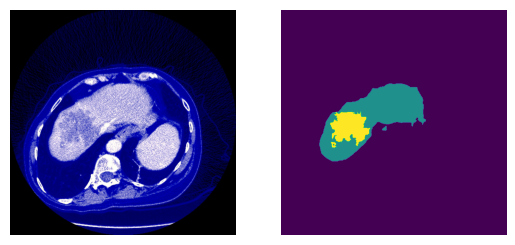

In [199]:
idx = 1000
imgs = [ds[idx][0],ds[idx][1]]
print(ds[idx][0])
fig, axs = plt.subplots(1, 2)

for i,ax in enumerate(axs.flatten()):
    ax.axis('off')
    ax.imshow(imgs[i])

In [23]:
def foreground_acc(inp, targ, bkg_idx=0, axis=1):  # exclude a background from metric
    "Computes non-background accuracy for multiclass segmentation"
    targ = targ.squeeze(1)
    mask = targ != bkg_idx
    return (inp.argmax(dim=axis)[mask]==targ[mask]).float().mean() 

def cust_foreground_acc(inp, targ):  # # include a background into the metric
    return foreground_acc(inp=inp, targ=targ, bkg_idx=3, axis=1) # 3 is a dummy value to include the background which is 0

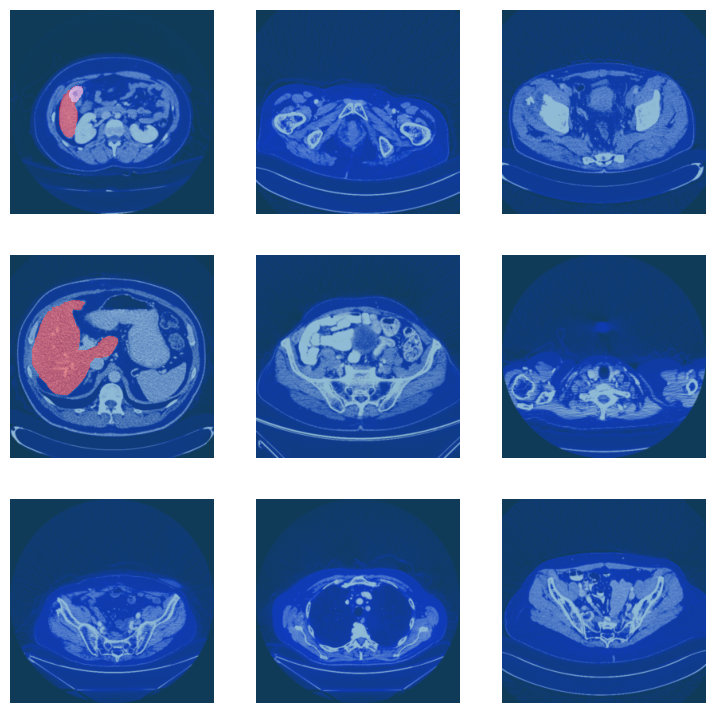

In [19]:
dls = db.dataloaders(path/'train_images', bs = BATCH_SIZE)
dls.show_batch()

In [25]:
learn = unet_learner(dls,
                     resnet50,
                     loss_func=CrossEntropyLossFlat(axis=1),
                     metrics=[foreground_acc, cust_foreground_acc])

In [54]:
learn.fine_tune(5, wd=0.1, cbs=SaveModelCallback())

epoch,train_loss,valid_loss,foreground_acc,cust_foreground_acc,time
0,0.019632,0.016969,0.906244,0.994320,19:31:21


Better model found at epoch 0 with valid_loss value: 0.016968555748462677.


C:\Users\HP\anaconda3\Lib\site-packages\fastai\learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,foreground_acc,cust_foreground_acc,time


KeyboardInterrupt: 

In [62]:
learn.save("Tumor_Detector")

Path('models/Tumor_Detector.pth')

### Evaluation

In [27]:
learn.load("Tumor_Detector")

C:\Users\HP\anaconda3\Lib\site-packages\fastai\learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

In [75]:
ct_scan_test = r"C:\Users\HP\Documents\CT Scans\volumes\volume-17.nii"
ct_array = read_nii(ct_scan_test)

In [165]:
slice_test = ct_array[..., 400].astype(np.float32)

In [167]:
# === Convert to FastAI image ===
tensor_slice = tensor(slice_test)
tensor_slice.save_jpg("test1.jpg", [dicom_windows.liver, dicom_windows.custom])

In [169]:
processed_image = Image.open("test1.jpg")
processed_image.save("test1.jpg")
processed_image = "test1.jpg"

In [29]:
pred, pred_idx, probs = learn.predict(ds[1000][0])

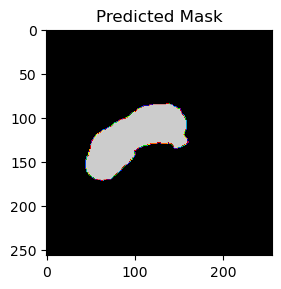

In [31]:
# processed_image = Image.open(ds[1000][0])
# plt.figure(figsize=(12,6))
# plt.subplot(1,2,1)
# plt.imshow(processed_image, cmap="bone")
# plt.title("Original CT Slice")

plt.subplot(1,2,2)
plt.imshow(pred.numpy(), cmap='nipy_spectral')
plt.title("Predicted Mask")
plt.show()

In [33]:
print("=== PREDICTION ANALYSIS ===")
print(f"Prediction tensor shape: {pred.shape}")
print(f"Unique values in prediction: {torch.unique(pred)}")
print(f"Value counts in prediction:")
pred_np = pred.numpy().flatten()
unique, counts = np.unique(pred_np, return_counts=True)
for val, count in zip(unique, counts):
    percentage = (count / len(pred_np)) * 100
    class_name = ["background", "liver", "tumor"][int(val)] if val < 3 else "unknown"
    print(f"  Class {val} ({class_name}): {count} pixels ({percentage:.2f}%)")

=== PREDICTION ANALYSIS ===
Prediction tensor shape: torch.Size([256, 256])
Unique values in prediction: TensorMask([0, 1])
Value counts in prediction:
  Class 0 (background): 60132 pixels (91.75%)
  Class 1 (liver): 5404 pixels (8.25%)


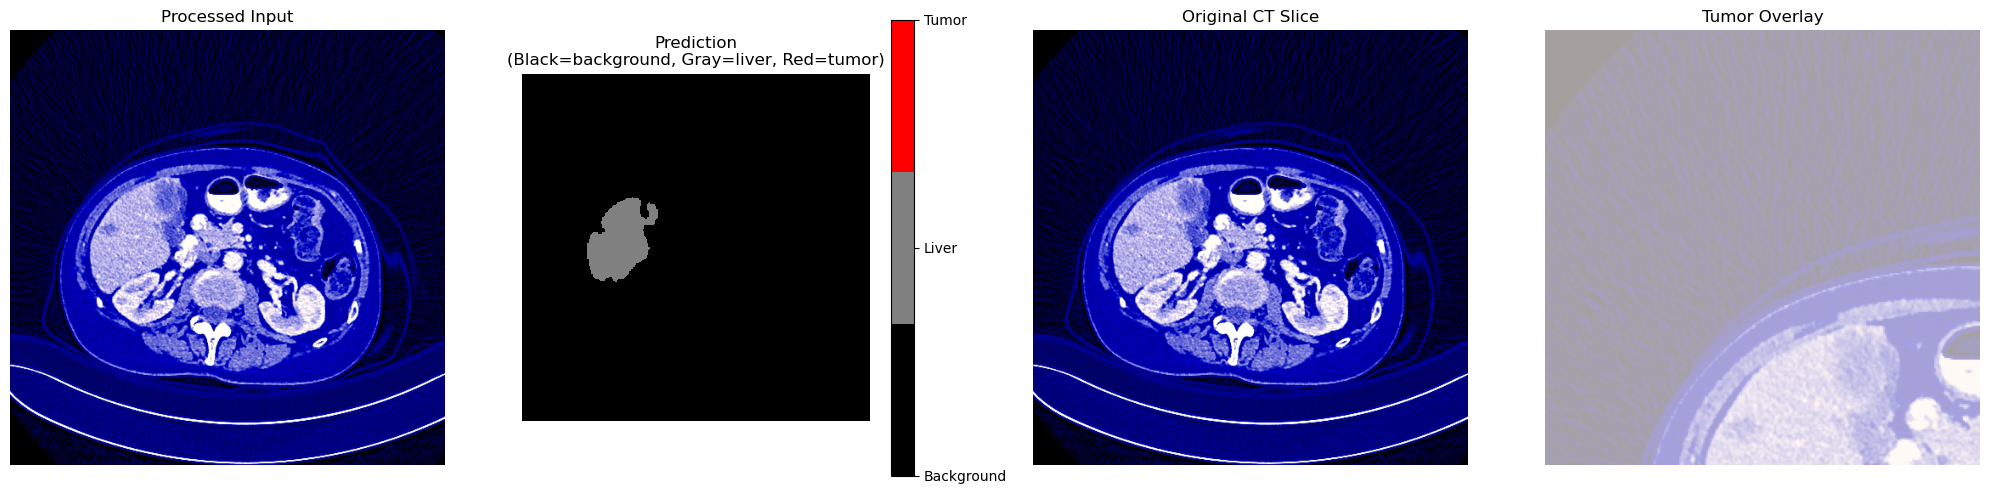

In [251]:
"""
Fixed visualization with proper color mapping for 3 classes
"""
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Show original processed image
test_img = Image.open(r"C:\Users\HP\train_images\volume-27_slice_394.jpg")
axes[0].imshow(test_img)
axes[0].set_title("Processed Input")
axes[0].axis('off')

# Show prediction mask with fixed colormap
pred_mask = pred.numpy()

# Create custom colormap for 3 classes
from matplotlib.colors import ListedColormap
colors = ['black', 'gray', 'red']  # background, liver, tumor
custom_cmap = ListedColormap(colors)

im = axes[1].imshow(pred_mask, cmap=custom_cmap, vmin=0, vmax=2)
axes[1].set_title("Prediction\n(Black=background, Gray=liver, Red=tumor)")
axes[1].axis('off')

# Add colorbar
cbar = plt.colorbar(im, ax=axes[1], ticks=[0, 1, 2])
cbar.ax.set_yticklabels(['Background', 'Liver', 'Tumor'])

# Show individual class probabilities
if hasattr(pred, 'probs') or len(pred.shape) > 2:
    # If we have probability maps
    axes[2].imshow(pred_mask == 1, cmap='Greys')  # Liver probability
    axes[2].set_title("Liver Regions")
    axes[2].axis('off')
    
    axes[3].imshow(pred_mask == 2, cmap='Reds')   # Tumor probability
    axes[3].set_title("Tumor Regions")
    axes[3].axis('off')
else:
    # Show original CT if available
    if processed_image is not None:
        axes[2].imshow(processed_image, cmap='bone')
        axes[2].set_title("Original CT Slice")
        axes[2].axis('off')
        
        # Show overlay
        overlay = processed_image.copy()
        tumor_mask = pred_mask == 2
        axes[3].imshow(overlay, cmap='bone', alpha=0.7)
        axes[3].imshow(tumor_mask, cmap='Reds', alpha=0.5)
        axes[3].set_title("Tumor Overlay")
        axes[3].axis('off')

plt.tight_layout()
plt.show()


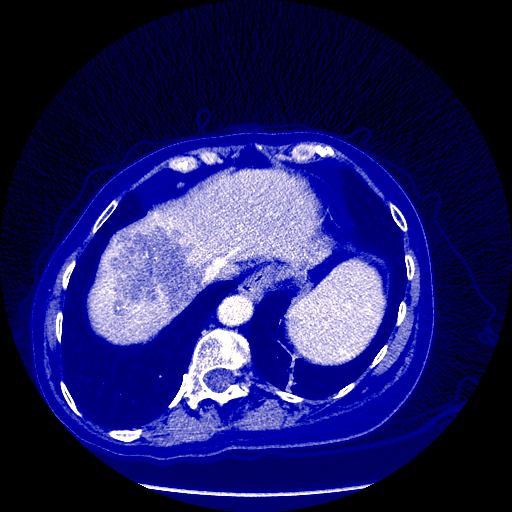